# Computing Reduced Density Matrices from MPO

### Basics Imports

In [1]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    #level=logging.INFO
    level=logging.DEBUG
)
logger = logging.getLogger('__name__')

In [2]:
import numpy as np
import pandas as pd
import sys

10/27/2023 05:51:42 PM-INFO: NumExpr defaulting to 8 threads.


### TensorNetworks imports

In [3]:
sys.path.append("../")
import tensornetworks as tn
import tn_quantum_circuits as tnqc
import gates as gt
from tensornetworks import contract_indices, contract_indices_one_tensor

### Imports QLM

In [4]:
import qat.lang.AQASM as qlm
from qat.qpus import PyLinalg
qpu_p = PyLinalg()
from qlm_stuff import proccess_qresults

## 1. Functions for creating the MPS

In [5]:
def apply_2qubit_gates(qubits, gates):
    """
    Executes product of tensor with a gate
    -o-o-o-o-o-..o-o-
     |   |   |     |
    """
    new_qubits = [0 for i in qubits]
    left = qubits[0]
    for i in range(1, len(qubits)):
        right = qubits[i]
        gate = gates[i-1]
        #new_qubits[i-1], left = phase_change(left, right, gate)
        new_qubits[i-1], left = tnqc.apply_2qubit_gate(left, right, gate)

    new_qubits[-1], new_qubits[0] = tnqc.apply_2qubit_gate(
        left, new_qubits[0], gates[-1])
     #new_qubits[-1], new_qubits[0] = phase_change(left, new_qubits[0], gates[-1])
    return new_qubits

In [6]:
def get_angles(depth):
    theta = np.pi/4.0
    delta_theta = theta / (depth + 1)
    angles = []
    for i in range(depth):
        angles.append([(2 * i + 1) * delta_theta, (2 * i + 2) * delta_theta])
    return angles     

In [7]:
def ansatz(nqubits, depth, angles):
    # Intitial State
    zeroket = np.zeros((1, 2, 1))
    zeroket[0][0][0] = 1
    zeroket = zeroket.astype(complex)
    #Initial State
    mps_ = [zeroket] * nqubits
    for depth_ in range(depth):
        # First Layer
        gates = [gt.x_rotation(angles[depth_][0]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
        ent_gates = [gt.controlz() for i in mps_]
        mps_ = apply_2qubit_gates(mps_, ent_gates)
        gates = [gt.z_rotation(angles[depth_][1]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
    return mps_

In [8]:
def ansatz_qlm(nqubits, depth, angles):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for d_ in range(0, depth):
        for i in range(nqubits):
            qprog.apply(qlm.RX(angles[d_][0]), qbits[i])
        for i in range(nqubits-1):
            qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
        qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])
        for i in range(nqubits):
            qprog.apply(qlm.RZ(angles[d_][1]), qbits[i])    
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ  

## 2. Creating MPS

In [9]:
# MPS uisng My code
depth = 3
nqubits = 10

In [10]:
free = [0, 1, 2, 3]
contraction = list(range(nqubits))
contraction = [i for i in contraction if i not in free]

In [11]:
%%time
mps = ansatz(nqubits, depth, get_angles(depth))
#rho_mps = reduced_rho_mps(mps, free, contraction)
#rho_mps_z = reduced_rho_mpo_z(mps, free, contraction)

10/27/2023 05:51:45 PM-DEBUG: tensor1: (1, 2, 1)
10/27/2023 05:51:45 PM-DEBUG: tensor2: (1, 2, 1)
10/27/2023 05:51:45 PM-DEBUG: Tensor1-Tensor2: (1, 4, 1)
10/27/2023 05:51:45 PM-DEBUG: Tensor1-Gate-Tensor2: (1, 4, 1)
10/27/2023 05:51:45 PM-DEBUG: Matrix for SVD : (2, 2)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation u_: (2, 2)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation vh: (2, 2)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation s_: (2,)
10/27/2023 05:51:45 PM-DEBUG: u_: (2, 2)
10/27/2023 05:51:45 PM-DEBUG: s_: (2,)
10/27/2023 05:51:45 PM-DEBUG: vh: (2, 2)
10/27/2023 05:51:45 PM-DEBUG: Left Tensor:, (1, 2, 2)
10/27/2023 05:51:45 PM-DEBUG: Right Tensor:, (2, 2, 1)
10/27/2023 05:51:45 PM-DEBUG: tensor1: (2, 2, 1)
10/27/2023 05:51:45 PM-DEBUG: tensor2: (1, 2, 1)
10/27/2023 05:51:45 PM-DEBUG: Tensor1-Tensor2: (2, 4, 1)
10/27/2023 05:51:45 PM-DEBUG: Tensor1-Gate-Tensor2: (2, 4, 1)
10/27/2023 05:51:45 PM-DEBUG: Matrix for SVD : (4, 2)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation u_: (

10/27/2023 05:51:45 PM-DEBUG: Tensor1-Tensor2: (4, 4, 2)
10/27/2023 05:51:45 PM-DEBUG: Tensor1-Gate-Tensor2: (4, 4, 2)
10/27/2023 05:51:45 PM-DEBUG: Matrix for SVD : (8, 4)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation u_: (8, 4)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation vh: (4, 4)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation s_: (4,)
10/27/2023 05:51:45 PM-DEBUG: u_: (8, 4)
10/27/2023 05:51:45 PM-DEBUG: s_: (4,)
10/27/2023 05:51:45 PM-DEBUG: vh: (4, 4)
10/27/2023 05:51:45 PM-DEBUG: Left Tensor:, (4, 2, 4)
10/27/2023 05:51:45 PM-DEBUG: Right Tensor:, (4, 2, 2)
10/27/2023 05:51:45 PM-DEBUG: tensor1: (4, 2, 2)
10/27/2023 05:51:45 PM-DEBUG: tensor2: (2, 2, 2)
10/27/2023 05:51:45 PM-DEBUG: Tensor1-Tensor2: (4, 4, 2)
10/27/2023 05:51:45 PM-DEBUG: Tensor1-Gate-Tensor2: (4, 4, 2)
10/27/2023 05:51:45 PM-DEBUG: Matrix for SVD : (8, 4)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation u_: (8, 4)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation vh: (4, 4)
10/27/2023 05:51:45 PM-DEBUG: Bef

10/27/2023 05:51:45 PM-DEBUG: Matrix for SVD : (16, 8)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation u_: (16, 8)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation vh: (8, 8)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation s_: (8,)
10/27/2023 05:51:45 PM-DEBUG: u_: (16, 8)
10/27/2023 05:51:45 PM-DEBUG: s_: (8,)
10/27/2023 05:51:45 PM-DEBUG: vh: (8, 8)
10/27/2023 05:51:45 PM-DEBUG: Left Tensor:, (8, 2, 8)
10/27/2023 05:51:45 PM-DEBUG: Right Tensor:, (8, 2, 4)
10/27/2023 05:51:45 PM-DEBUG: tensor1: (8, 2, 4)
10/27/2023 05:51:45 PM-DEBUG: tensor2: (4, 2, 4)
10/27/2023 05:51:45 PM-DEBUG: Tensor1-Tensor2: (8, 4, 4)
10/27/2023 05:51:45 PM-DEBUG: Tensor1-Gate-Tensor2: (8, 4, 4)
10/27/2023 05:51:45 PM-DEBUG: Matrix for SVD : (16, 8)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation u_: (16, 8)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation vh: (8, 8)
10/27/2023 05:51:45 PM-DEBUG: Before Truncation s_: (8,)
10/27/2023 05:51:45 PM-DEBUG: u_: (16, 8)
10/27/2023 05:51:45 PM-DEBUG: s_: (8,)
10/27/202

CPU times: user 519 ms, sys: 190 ms, total: 709 ms
Wall time: 461 ms


In [12]:
%%time
#Stat of circuit for comparing with MPS computations
pdf, c= ansatz_qlm(nqubits, depth,  get_angles(depth))
# Computing Density Matrix using reduced_matrix for pure tensors
amp = np.array(pdf["Amplitude"])
amp = amp.reshape(tuple([2 for i in range(nqubits)]))
rho_qlm = tn.reduced_matrix(amp, free, contraction)

10/27/2023 05:51:46 PM-INFO: Generating circuit.
10/27/2023 05:51:46 PM-INFO: Instantiating a Linker.
10/27/2023 05:51:46 PM-INFO: Linking libraries to circuit.
10/27/2023 05:51:46 PM-INFO: Found 0 ancillae
10/27/2023 05:51:46 PM-INFO: New batch of length 1 submitted
10/27/2023 05:51:46 PM-DEBUG: Batch(jobs=[Job(circuit=Circuit(ops=[Op(gate='_0', qbits=[0], type=0, cbits=None, formula=None, remap=None), Op(gate='_0', qbits=[1], type=0, cbits=None, formula=None, remap=None), Op(gate='_0', qbits=[2], type=0, cbits=None, formula=None, remap=None), Op(gate='_0', qbits=[3], type=0, cbits=None, formula=None, remap=None), Op(gate='_0', qbits=[4], type=0, cbits=None, formula=None, remap=None), Op(gate='_0', qbits=[5], type=0, cbits=None, formula=None, remap=None), Op(gate='_0', qbits=[6], type=0, cbits=None, formula=None, remap=None), Op(gate='_0', qbits=[7], type=0, cbits=None, formula=None, remap=None), Op(gate='_0', qbits=[8], type=0, cbits=None, formula=None, remap=None), Op(gate='_0', qbi

10/27/2023 05:51:46 PM-INFO: Compiling a batch of length 1
10/27/2023 05:51:46 PM-INFO: Starting compilation...
10/27/2023 05:51:46 PM-INFO: Returning compiled batch.
10/27/2023 05:51:46 PM-INFO: Resource management is not available, passing through.
10/27/2023 05:51:46 PM-INFO: Running jobs...
10/27/2023 05:51:46 PM-INFO: Done
10/27/2023 05:51:46 PM-DEBUG: Obtained results : [Result(need_flip=False, lsb_first=False, nbqbits=None, has_statevector=False, statevector=None, data=None, _value=None, raw_data=[Sample(_amplitude=ComplexNumber(re=-0.02865490577329862, im=-0.10065965511845193), probability=0.010953469793442309, _state=0, err=None, intermediate_measurements=[], qregs=None), Sample(_amplitude=ComplexNumber(re=0.026871350653245047, im=-0.056017860094964046), probability=0.0038600701355486185, _state=1, err=None, intermediate_measurements=[], qregs=None), Sample(_amplitude=ComplexNumber(re=0.02687135065324507, im=-0.05601786009496405), probability=0.0038600701355486202, _state=2, e

10/27/2023 05:51:46 PM-INFO: Post processing a list of results of length 1
10/27/2023 05:51:46 PM-INFO: Wrapping results using 1 quantum registers
10/27/2023 05:51:46 PM-DEBUG: matrix_state_shape: (16, 64)


CPU times: user 329 ms, sys: 19.8 ms, total: 349 ms
Wall time: 198 ms


## 3. Reduced Rho

This is what we want to compute

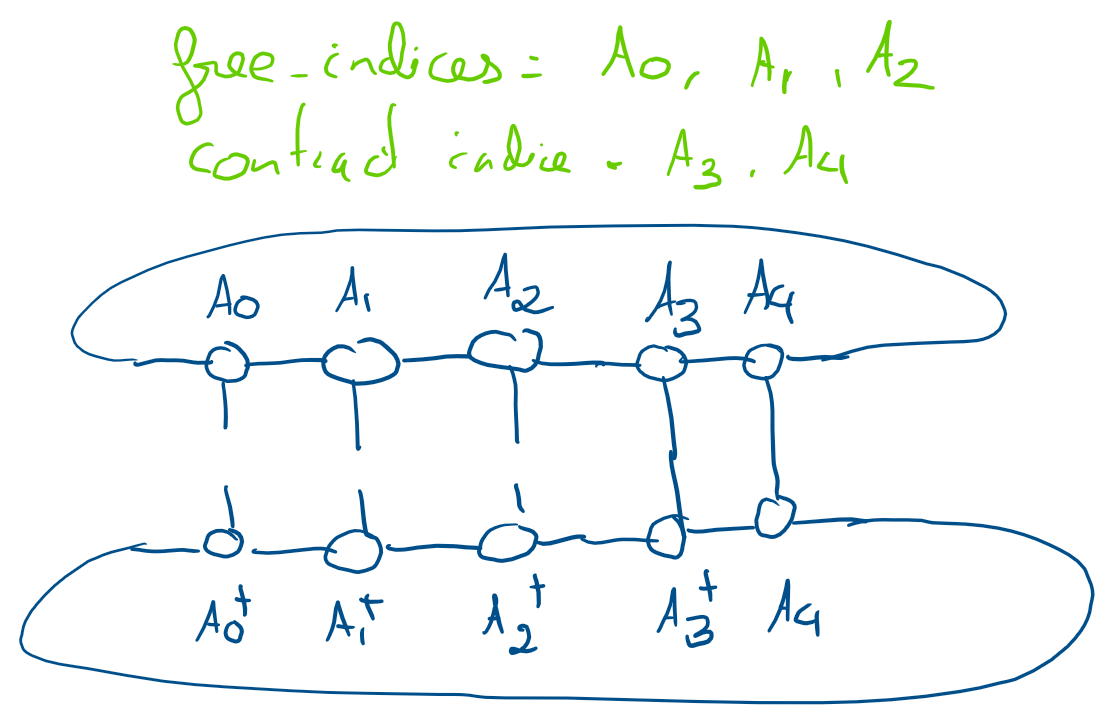

We are going to split computation in **free** and **contracted** indices.

### Free Indices

This is how to compute the free indices contractions:

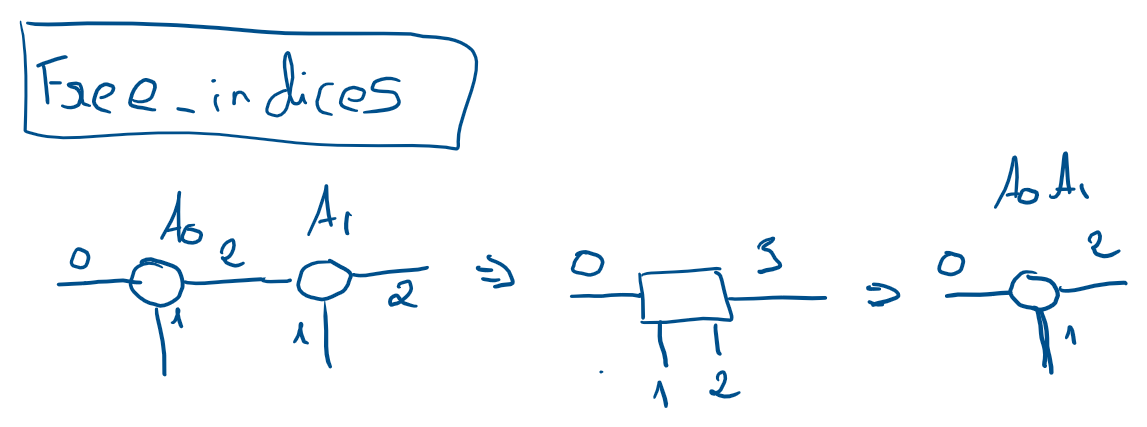

### Contracted Indices
This is the computations done in Contracted indices
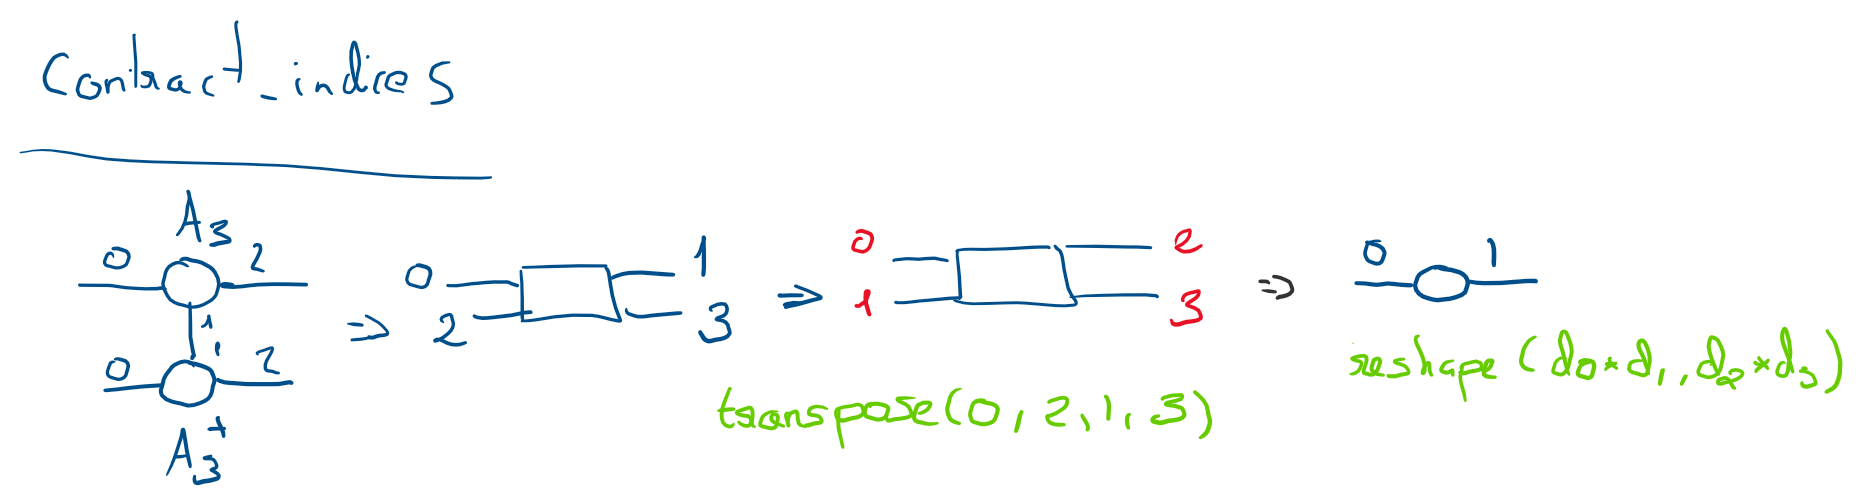

### Final Contractions

Now we can contract all the pieces for getting the desired reduced density matrix

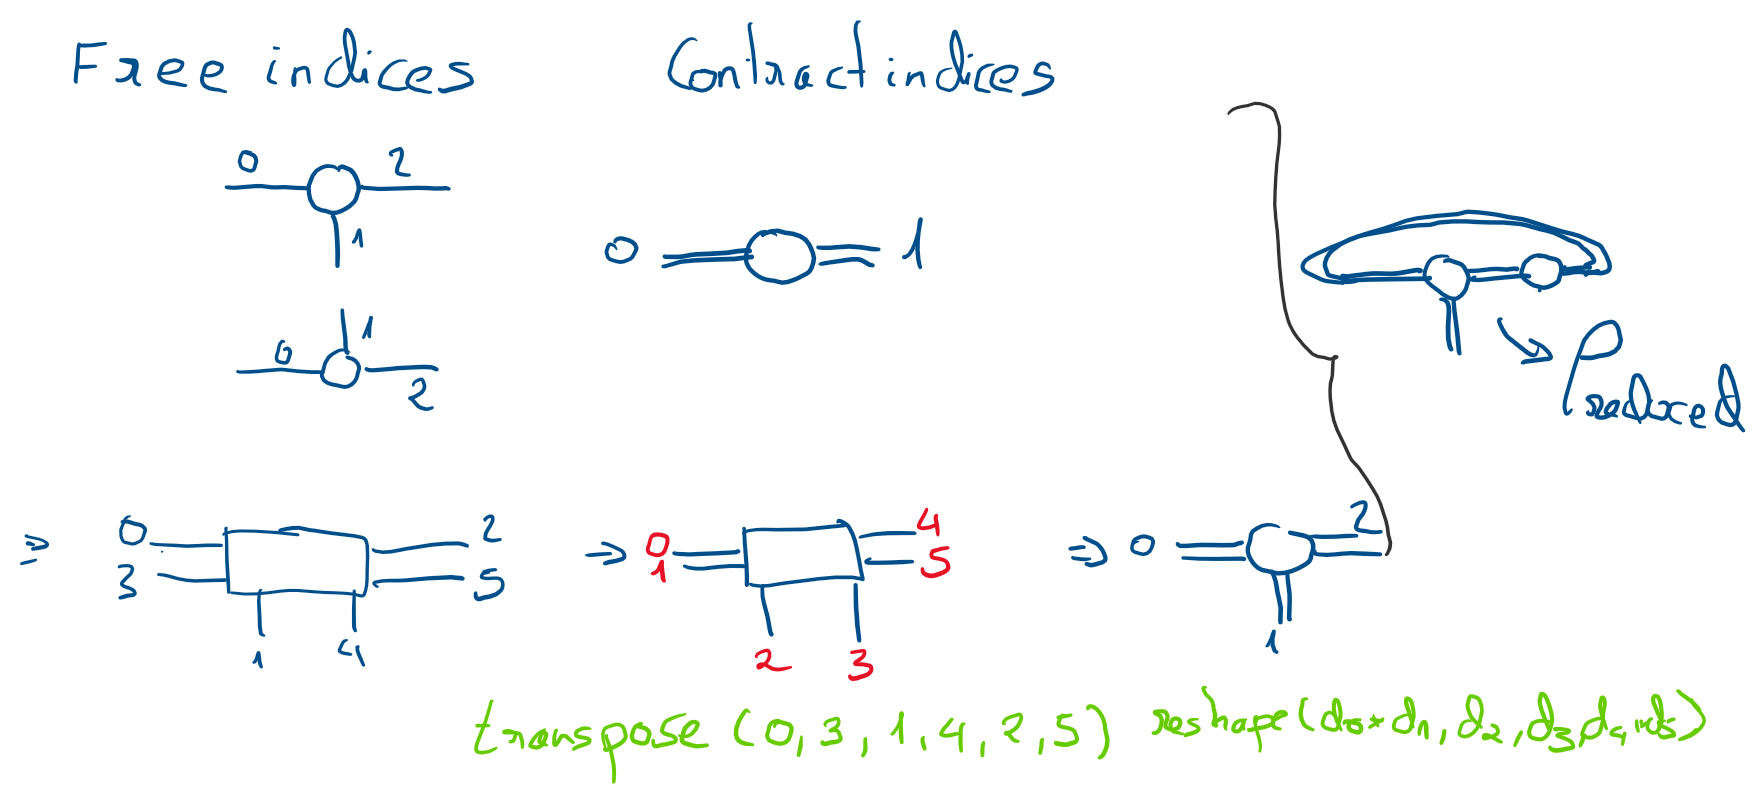

In [13]:
from reduced_rho import reduced_rho_mps

In [14]:
rho_mps = reduced_rho_mps(mps, free, contraction)

10/27/2023 05:51:50 PM-DEBUG: Free tensor: (16, 16, 8)


In [15]:
np.isclose(rho_mps, rho_qlm).all()

True

In [16]:
np.sqrt(256)

16.0